# Read IDL results  for Celerite

In [1]:
import linmix
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import os
import scipy
import matplotlib.lines as mlines
import seaborn as sns 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



* [code for celerite $\tau$, $SF$: Fig.19/20](#)
    * [plotting various subsamples](#celeriteTauSF_sub)
    * [production: Fig 19/20](#celeriteTauSF)
    * [production: Table 2](#celeriteTauSF_table)
* [Table2 with results summary](#table2)

The IDL fitting was done with code residing in  `../IDL/` , using as Chelsea's results the combined `s82drw_ugriz.txt`, from `../code/CA_linmix_fit_Chelsea.ipynb`. Those were **uncorrected**  $\tau$, $SF_{\infty}$, but the IDL code does the correction before fitting given the `lambdaRF` column  ( uaing -0.479 for $SF_{\infty}$,  0.17 for  $\tau$ ) : 

    readpath = '/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/IDL/'
    s82file = '/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/s82drw_ugriz.txt'  ; Chelsea's results 
   
    data = READ_ASCII(s82file, comment_symbol='#', header=h, data_start=1)
    d  = data.(0) ; contains the data 

    ; for Chelsea's data :  
    ;  d[0,*] ra    d[1,*]  dec     d[2,*]  SFinf    d[3,*] log10tau   d[4,*] lambdaRF   
    ;  d[5,*] M_i  d[6,*] M_i_corr  d[7,*] MI_Z2    d[8,*] mass_BH   d[9,*] mass_BH_Shen2011 
    ; d[10,*] redshift  d[11,*] band 


    var = d[2,*]^2  ;  SFinf^2 
    redshift = d[10,*] 
    log10tauOBS = d[3,*]
    ;-  convert observed to rest-frame :
    ; # tauRF = tauOBS / (1+z)
    ; so log10(tauRF) = log10(tauOBS) - log10(1+z)
    log10tauRF = log10tauOBS - alog10(1.0 + redshift) ; tau is log10(tauRF)
    tau = log10tauRF 

    lRF = d[4,*] 
    ;M_i_corr = d[5,*] ; MI K-corr to z=0  DB QSO 
    ;M_i_corr = d[6,*] ; MI K-corr to z=2 from DBQSO , 'M_i_corr', slightly different than Shen2011 MI_Z2 
    ;M_i_corr = d[7,*] + 0.596  ; shifting M(z=2) to M(z=0) via Richards2006 eq.1 :   M(z=0) = M(z=2) + 0.596 
    M_i_corr = d[7,*] ; MI_Z2 : k-corr to  z=2  , Shen2011
    ;mass_bh =  d[8,*] ; DB QSO 
    mass_bh = d[9,*] ; Shen 2011

    band = d[11,*]

    close,2
    close,3
    suffix = '_E0a'
    coeff_fileSF  = readpath+'coeffSFo_mcmc2'+suffix+'.dat'
    coeff_filetau = readpath+'coefftauo_mcmc2'+suffix+'.dat'
    openw, 2, coeff_fileSF
    openw, 3, coeff_filetau

    for iba = 1,5 do begin     ; Fit each band separately, then take RMS as error
       print,iba
       fitsfileSF  = readpath+'coeffSFo_mcmc2_'+strtrim(iba,1)+suffix+'.fits'
       fitsfiletau = readpath+'coefftauo_mcmc2_'+strtrim(iba,1)+suffix+'.fits'

       slice = [where(mass_bh gt 0 and band eq iba)] ; Select band and require nonzero BH mass

       f = (alog10(sqrt(var)))    [slice]  ; SF_inf array
       x = (alog10(lRF/4000.))    [slice]  ; Rest-wavelength array
       y = (M_i_corr+23.)         [slice]  ; Absolute Magnitude M_i, K-corrected to z=0
       z = (mass_bh-9.)           [slice]  ; BH mass in 10^9 solar masses
       red = (alog10(1.+redshift))[slice]  ; redshift array; not needed


       ; First, **remove wavelength trend: **
       lampwrsf = -0.479
       fo = f - lampwrsf*x 




So given that, read in the results of IDL fitting each of the five SDSS bands separately . This is Chelsea's DRW params (separately for each band), correlated against Shen2011 MBH, MI,  redshift. 

Results for  SF


FileNotFoundError: [Errno 2] No such file or directory: '../IDL/190606_celerite_MI_Z2_SDSS/coeffSFo_mcmc2_1_E0a.fits'

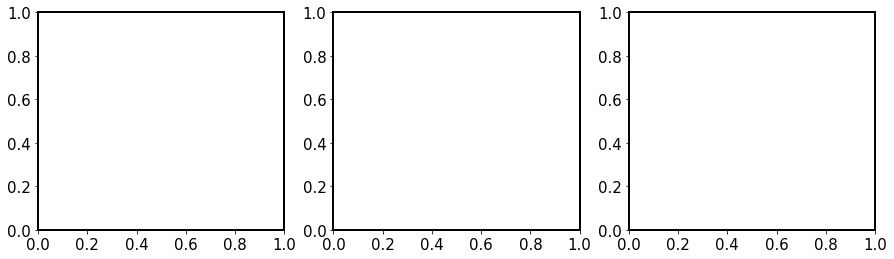

In [2]:
# Read in the results of MLINMIX_ERR fitting ....
%matplotlib inline
import matplotlib.lines as mlines
import seaborn as sns 
current_palette = sns.color_palette()

# this used M_i from s82drw 
fig,ax = plt.subplots(1,3, figsize=(15,4))
A=[]; C=[]; D=[]
b = 'ugriz'
par = 'SF'#'tau'#'SF'# 'SF'#'tau'#  'SF'#tau' # 'SF' 
lw=2
nbins = 25
ax_legend_handles =  []
print('Results for ', par)

lw_not_r = 2
ls_not_r = '--'
alpha_not_r = 0.7
lw = {1:lw_not_r,2:lw_not_r,3:3,  4:lw_not_r,5:lw_not_r}
ls = {1:ls_not_r,2:ls_not_r,3:'-',4:ls_not_r,5:ls_not_r}
alpha = {1:alpha_not_r,2:alpha_not_r, 3:1 , 4:alpha_not_r, 5:alpha_not_r  }
for i in range(1,6):
    #d = '../IDL/line5_ACD_M_i/'   # using 'M_i' - K -corrected to z=0 DBQSO
    #d = '../IDL/line5_ACD_M_i_corr/'   # using 'M_i_corr' - K -corrected to z=2 DBQSO
    #d = '../IDL/line5_ACD_MI_Z2_shifted/'     # using 'MI_Z2 + 0.596  - K-corrected to z=0 
    #d = '../IDL/line5_ACD_MI_Z2/'  # using MI_Z2  - K-corrected to z=2 
    #d = '../IDL/mlinmixerr2_line5_ACD_MI_Z2/' # using 'MI_Z2', k-corr to z=2, 
                                            # but with mlinmix_err2
    #d = '../IDL/mlinmixerr2_line5_ACD_M_i/'# using 'M_i" k-corr to z=0
    
    
    d = '../IDL/190606_celerite_MI_Z2_SDSS/' 
    #d = '../IDL/190606_celerite_MI_Z2_SDSS-PS1/'
    
    f = 'coeff'+par+'o_mcmc2_'+str(i)+'_E0a.fits'
    post = Table.read(d+f, format='fits')
    
    c = current_palette[i-1]
    
    ax[0].hist(post['ALPHA'],histtype='step',color=c,lw=lw[i], ls=ls[i],
               alpha=alpha[i], bins=nbins)
    A.append(np.mean(post['ALPHA']))
    print(i, 'mean A=', np.mean(post['ALPHA']))
    
    ax[1].hist(post['BETA'][:,0],histtype='step',color=c,lw=lw[i], ls=ls[i],
               alpha=alpha[i], bins=nbins)
    print(i, 'mean C=', np.mean(post['BETA'][:,0]))
    C.append(np.mean(post['BETA'][:,0]))
    
    ax[2].hist(post['BETA'][:,1],histtype='step',color=c,lw=lw[i], ls=ls[i],
               alpha=alpha[i], bins=nbins)
    print(i, 'mean D=', np.mean(post['BETA'][:,1]))
    D.append(np.mean(post['BETA'][:,1]))
    
    line = mlines.Line2D([], [],  color=c, label=b[i-1], lw=lw[i], ls=ls[i],
               alpha=alpha[i])
    ax_legend_handles.append(line)
    
ax[0].set_ylabel('count')
ax[0].set_xlabel('A (offset)')

ax[1].set_xlabel('C '+r'$(M_{i})$')

ax[2].set_xlabel('D '+r'$(M_{BH})$')


coeffs = [A,C,D]
for i in range(len(coeffs)) : 
    # plot the band-averaged mean 
    ax[i].axvline(np.mean(coeffs[i]), ls='--', lw=3, c='red', alpha=alpha_not_r)
 
    # plot the r-band mean : ug r iz =  01 2 34 here 
    ax[i].axvline(coeffs[i][2], ls='-', lw=3, c='green', alpha=1)

ax[2].legend(loc='upper left', handles = ax_legend_handles,
             bbox_to_anchor=(0.98, 0.9), fontsize=15,fancybox=True)
fig.subplots_adjust(wspace=0.32)

print('Band-averaged A = ', np.mean(A),)
print('Band-averaged C = ', np.mean(C))
print('Band-averaged D = ', np.mean(D))
#mlinmix_diff['mlinmix3'] = [np.mean(A), np.mean(C), np.mean(D)]
if par  == 'SF':
    fig.suptitle('f = ' + par + r'$_{\infty}$', fontsize=20)
if par  =='tau' :
    fig.suptitle('f = '+ r'$\tau$', fontsize=20)
figname = 'Chelsea_ugriz_Shen2011_'+par+'.png'
print('Saved as ', figname)
plt.savefig(figname, bbox_inches='tight', dpi=100)

In [11]:
coeffs[2]

[0.14811451173144377,
 0.1451527604077876,
 0.11976867053250172,
 0.11583378556857163,
 0.10978183889787496]

show the single-band results .... 

3 mean A= 2.603463671159337
3 mean C= 0.022398178266601256
3 mean D= 0.16389184026061931


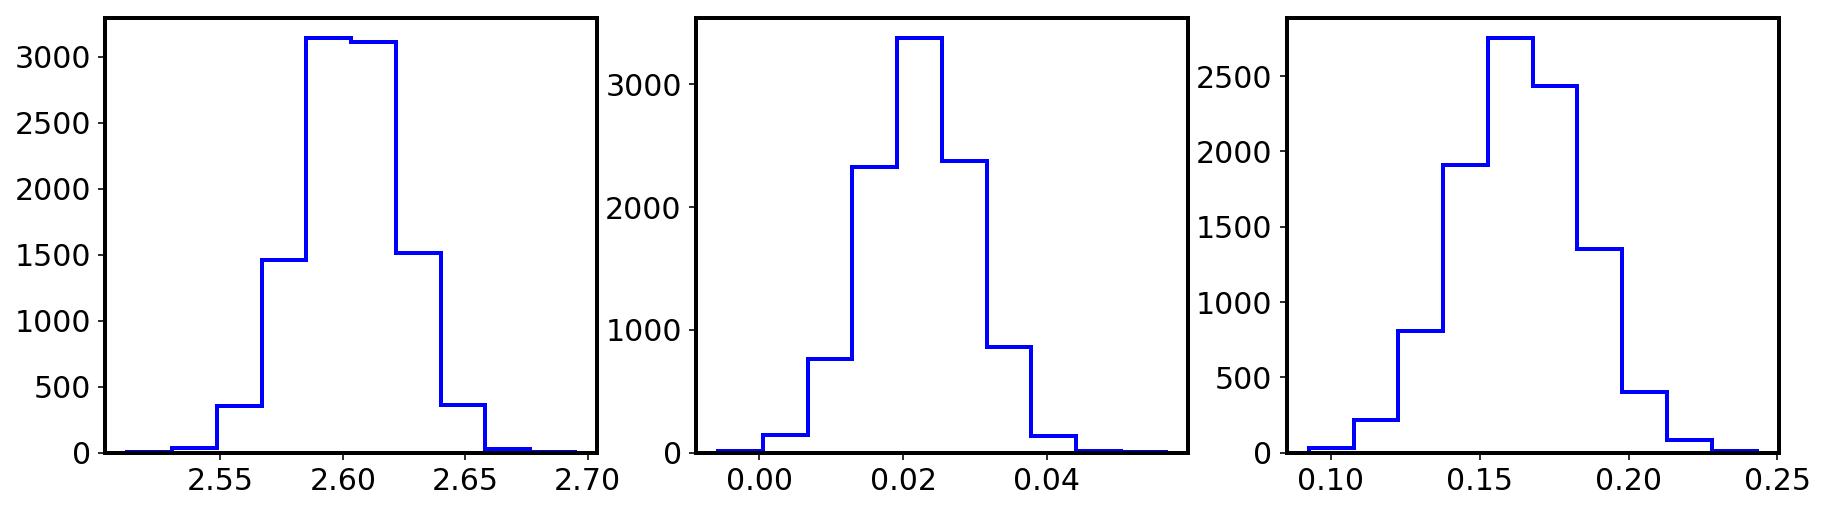

In [131]:
%matplotlib inline

band = 3 
par = 'tau'
f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'
#d = '../IDL/line5_ACD_M_i_corr/'
#d = '../IDL/line5_celerite_ACD_M_i_corr_SDSS-PS1/'
#d = '../IDL/line5_celerite_ACD_M_i_corr_SDSS/'
d = '../IDL/line5_celerite_MI_Z2_SDSS/'
c = 'blue'
lw=2
post = Table.read(d+f, format='fits')

fig,ax = plt.subplots(1,3, figsize=(15,4))
A=[]; C=[]; D=[]

ax[0].hist(post['ALPHA'],histtype='step',color=c,lw=lw)
A.append(np.mean(post['ALPHA']))
print(band, 'mean A=', np.mean(post['ALPHA']))

ax[1].hist(post['BETA'][:,0],histtype='step',color=c,lw= lw)
print(band, 'mean C=', np.mean(post['BETA'][:,0]))
C.append(np.mean(post['BETA'][:,0]))

ax[2].hist(post['BETA'][:,1],histtype='step',color=c,lw=lw )
print(band, 'mean D=', np.mean(post['BETA'][:,1]))
D.append(np.mean(post['BETA'][:,1]))



Compare posterior samples, all using IDL with M_i_corr,  mass_bh (Shen2008)
    * Chelsea r-band  
    * Celerite, combined r-band, SDSS only 
    * Celerite, combined r-band, SDSS-PS1 

 
../IDL/M10_line5_ACD_MI_Z2/
3 mean A= 2.4323886272897273
3 mean C= 0.011207336099430625
3 mean D= 0.16309971616965474
 
../IDL/190606_celerite_MI_Z2_SDSS/
3 mean A= 2.5935846720633635
3 mean C= 0.03503721675181938
3 mean D= 0.1796668590408611
 
../IDL/190606_celerite_MI_Z2_SDSS-PS1/
3 mean A= 2.6545550494371337
3 mean C= 0.030338726838966188
3 mean D= 0.16978619748124596
Saving as  posterior_IDL_Chelsea_Celerite_MI_Z21.png


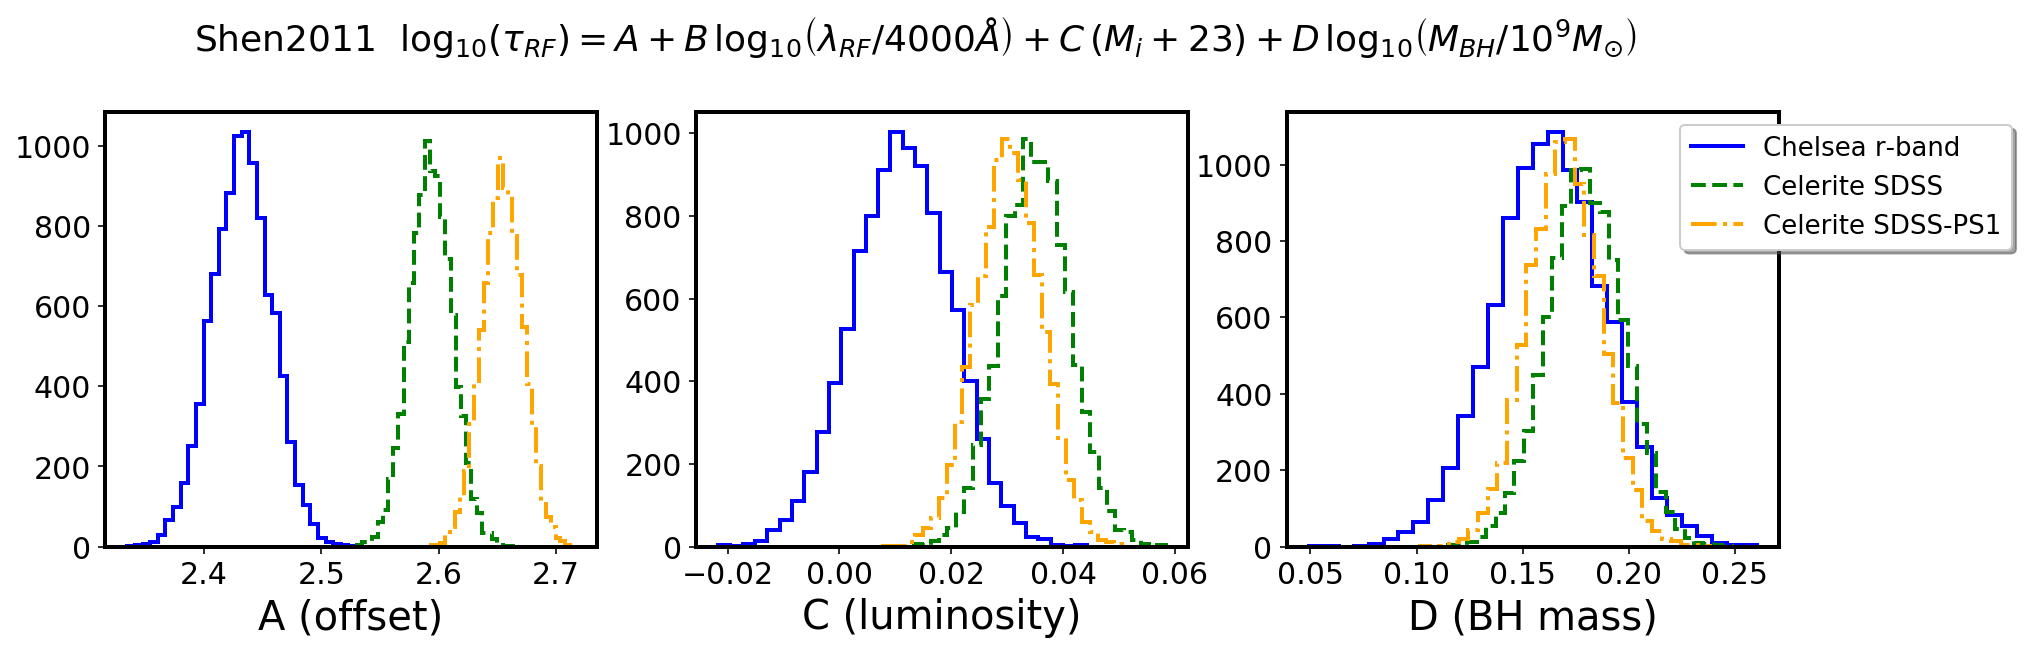

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
band = 3 
par = 'tau'
f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'

catalog = 'MI_Z2'# 'M_i_corr' #  # 'M_i_corr' # 'M_i_corr  
pre = 'Shen2011'# 'Shen2008'# 
ds = ['../IDL/M10_line5_ACD_'+catalog+'/',
'../IDL/190606_celerite_'+catalog+'_SDSS/',
'../IDL/190606_celerite_'+catalog+'_SDSS-PS1/']
colors= ['blue','green', 'orange',  'red']
ls = ['solid' , 'dashed', 'dashdot', 'dotted',  ]
labels = ['Chelsea r-band', 'Celerite SDSS', 'Celerite SDSS-PS1']
lw=2
A=[]; C=[]; D=[]
fig,ax = plt.subplots(1,3, figsize=(15,4))
i = 0 
ax_legend_handles = [] 
nbins = 30
for d in ds : 
    print(' ')
    print(d)
    post = Table.read(d+f, format='fits')
    ax[0].hist(post['ALPHA'],histtype='step',color=colors[i],lw=lw, 
               ls=ls[i],bins=nbins)
    A.append(np.mean(post['ALPHA']))
    print(band, 'mean A=', np.mean(post['ALPHA']))

    ax[1].hist(post['BETA'][:,0],histtype='step',color=colors[i],lw= lw,
               ls=ls[i],bins=nbins)
    print(band, 'mean C=', np.mean(post['BETA'][:,0]))
    C.append(np.mean(post['BETA'][:,0]))

    ax[2].hist(post['BETA'][:,1],histtype='step',color=colors[i],lw=lw ,
               ls=ls[i],bins=nbins)
    print(band, 'mean D=', np.mean(post['BETA'][:,1]))
    D.append(np.mean(post['BETA'][:,1]))

    line = mlines.Line2D([], [],  color=colors[i], label=labels[i],lw=2,
                        ls=ls[i])
    ax_legend_handles.append(line)
    i += 1 
ax[2].legend(loc='upper right', handles = ax_legend_handles,
             bbox_to_anchor=(1.5, 1.0),
             ncol=1, fancybox=True, shadow=True, fontsize=13 ) 
fig.suptitle(pre+'  '+r'$\log_{10}{(\tau_{RF})} = A + $'+\
             r'$B \,\log_{10}\left( \lambda_{RF} / 4000 \AA \right) +$'+\
             r'$C \,(M_{i} + 23) + $'+\
             r'$D\, \log_{10}{\left( M_{BH} / 10^{9} M_{\odot}  \right)}  $'
       , fontsize=18, y = 1.05)


ax[0].set_xlabel('A (offset)')
ax[1].set_xlabel('C (luminosity)')
ax[2].set_xlabel('D (BH mass)')
figname  = 'posterior_IDL_Chelsea_Celerite_'+catalog+'1.png'
print('Saving as ', figname)
plt.savefig(figname, bbox_inches='tight',
           dpi=100)

Plot the above only for C,D coeffs  : 

In [103]:
length = 4 
a = np.zeros(length).astype(float)
a[0] = 23.4

## Results for Celerite / M10: subsamples <a id='celeriteTauSF_sub'></a>

 
../IDL/190729_M10_MI_Z2_good/
3 mean C= 0.11867246235177449
3 mean D= 0.12060496659834957
 
../IDL/190807_celerite_MI_Z2_SDSS_M10_good/
3 mean C= 0.12546597145850893
3 mean D= 0.10362488999283885
 
../IDL/190807_celerite_MI_Z2_SDSS_S0/
3 mean C= 0.131571176879401
3 mean D= 0.11634840159241722
 
../IDL/190807_celerite_MI_Z2_SDSS_S1/
3 mean C= 0.11923209118595254
3 mean D= 0.07813366486341312
 
../IDL/190807_celerite_MI_Z2_SDSS_S2/
3 mean C= 0.13021499697961952
3 mean D= 0.11832689466719334
 
../IDL/190807_celerite_MI_Z2_SDSS_S3/
3 mean C= 0.12735620102763823
3 mean D= 0.10876485695212455
 
../IDL/190807_celerite_MI_Z2_SDSS_S4/
3 mean C= 0.12453708621397008
3 mean D= 0.07957204930359861
 
../IDL/190807_celerite_MI_Z2_SDSS_S5/
3 mean C= 0.12827835444617244
3 mean D= 0.11014616281199739
Saving as  posterior_IDL_Chelsea_Celerite_CD_MI_Z2_SF1_SDSS.png
 
../IDL/190729_M10_MI_Z2_good/
3 mean C= 0.029518762014690714
3 mean D= 0.17770775941826492
 
../IDL/190807_celerite_MI_Z2_SDSS_M10_good/
3

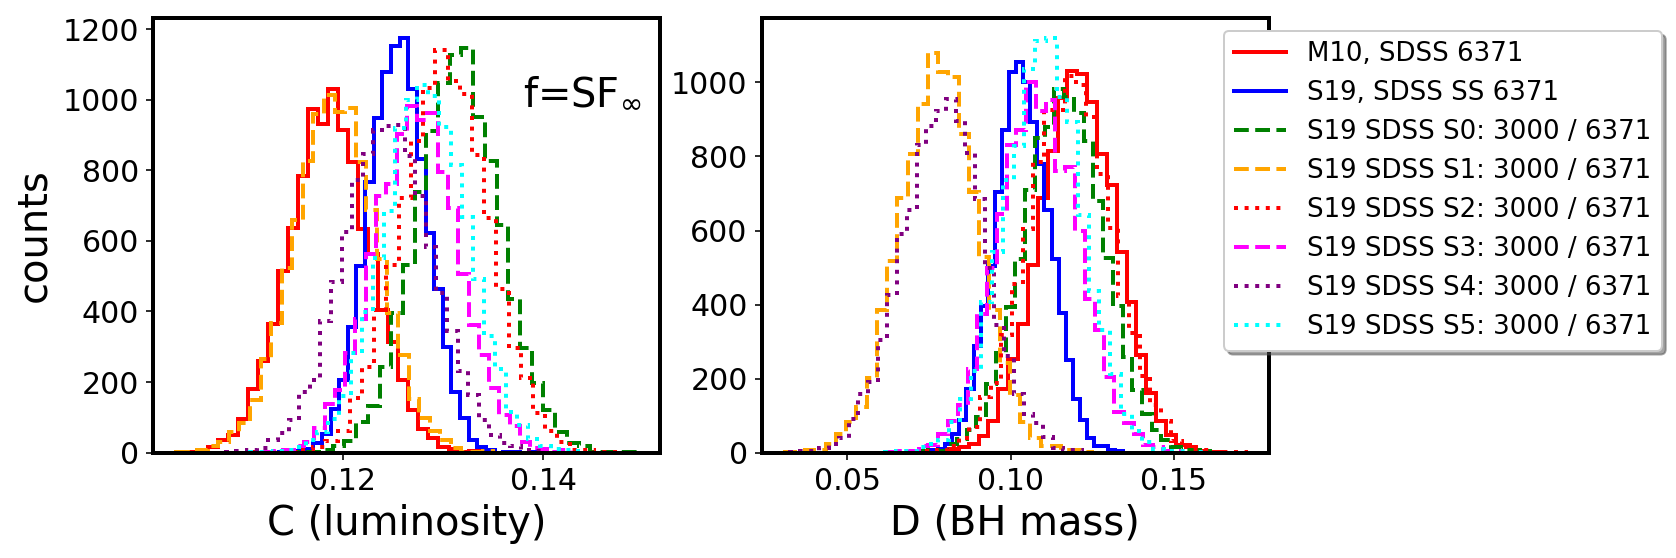

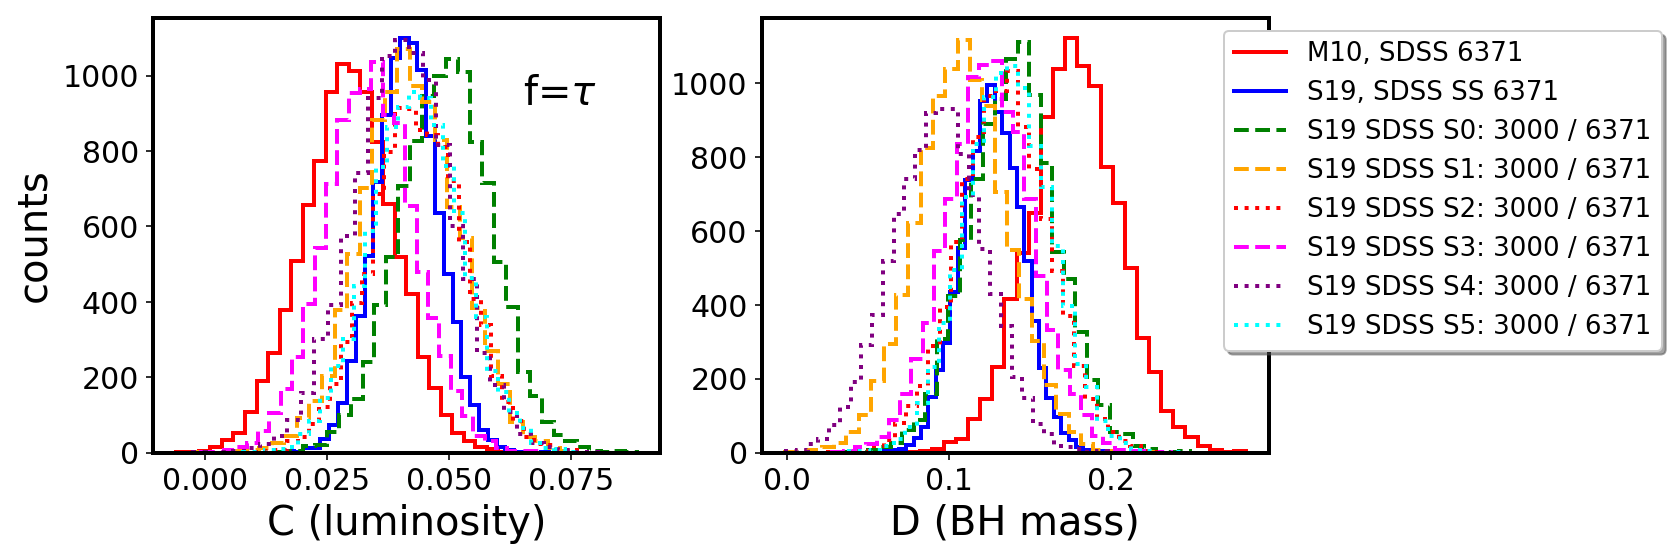

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
band = 3 

 # 'tau'# 'SF'#'tau' #  'SF' # \tau

length = 18
results = {'f': np.zeros(length).astype(str), 
           'source':np.zeros(length).astype(str),
           'A':np.zeros(length).astype(float), 
           'A_unc':np.zeros(length).astype(float),
           'B':np.zeros(length).astype(float), 
           'B_unc':np.zeros(length).astype(float),
           'C':np.zeros(length).astype(float),  
           'C_unc':np.zeros(length).astype(float), 
           'D':np.zeros(length).astype(float) , 
           'D_unc':np.zeros(length).astype(float)
          }

catalog = 'MI_Z2'# 'M_i_corr' #  # 'M_i_corr' # 'M_i_corr  
pre = 'Shen2011'# 'Shen2008'# 
# date = '190228'
# ds = ['../IDL/M10_line5_ACD_'+catalog+'/',
# '../IDL/'+date+'_celerite_'+catalog+'_SDSS/',
# '../IDL/'+date+'_celerite_'+catalog+'_SDSS-PS1/']
date = '190807'#'190606'#'190807'#'190606'

sup = '1'# '1' # good,  '2' : all 
survey = 'SDSS'
if sup is '1':
    title  = ''#'v1: 6371 quasars that fulfill M10 selection'
    ds = ['../IDL/190729_M10_'+catalog+'_good/', # 6371 / 6871  
        #  '../IDL/190228_celerite_'+catalog+'_SDSS/',  # 4968  of 6444 , the inner join ... 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_M10_good/',  # 6371 / 8516 
  # '../IDL/'+date+'_celerite_'+catalog+'_SDSS-PS1_M10_good/', # 6371 / 8516
#     '../IDL/'+date+'_celerite_'+catalog+'_SDSS_subset/' , # 3567 / 4968 in 190228 that were in M10
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S0/', # 3000 / 6371 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S1/', # 3000 / 6371
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S2/', # 3000 / 6371
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S3/', # 3000 / 6371
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S4/', # 3000 / 6371
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S5/', # 3000 / 6371
         ]
if sup is '2':
    title = 'v2: 8516 SDSS-PS1 quasars with Celerite results'
    ds = ['../IDL/190729_M10_'+catalog+'/', # 6371 / 6871 
 #   '../IDL/'+date+'_celerite_'+catalog+'_SDSS/', # all 8516
     '../IDL/'+date+'_celerite_'+catalog+'_SDSS-PS1/'# all 8516
         ]


# matched to the 6871 M10 r-band that  fulfill M10 selection criteria...

colors= ['red','blue','green', 'orange',  'red', 'magenta', 'purple', 'cyan']
ls = ['solid','solid' ,  'dashed', 'dashed', 'dotted', 'dashed',  'dotted', 'dotted']
labels = ['M10, SDSS 6371',
         # 'S19, SDSS 4968',
        # 'S19, SDSS raw',
        # 'S19, SDSS cleaned ',
       #  'S19, SDSS-PS1',
         'S19, '+survey+' SS 6371',
         'S19 '+survey+' S0: 3000 / 6371',  # three random subsets of M10 good set 
         'S19 '+survey+' S1: 3000 / 6371', 
         'S19 '+survey+' S2: 3000 / 6371',
         'S19 '+survey+' S3: 3000 / 6371',
         'S19 '+survey+' S4: 3000 / 6371',
         'S19 '+survey+' S5: 3000 / 6371',
         ]
# labels = ['M10, 6871 QSO, SDSS', 'S19, 6371 QSO, SDSS ', 
#           'S19, 6371 QSO, SDSS-PS1 ',
#           'S19, 8516 QSO, SDSS',
#           'S19, 8516 QSO, SDSS-PS1'
#          ]
k = 0 
for par in ['SF','tau' ] : 
    f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'
    lw=2
    A=[]; C=[]; D=[]
    fig,ax = plt.subplots(1,2, figsize=(10,4))
    i = 0 
    ax_legend_handles = [] 
    nbins = 30
    for d in ds : 
        results['f'][k] = par
        results['source'][k] = labels[i] 
        
        print(' ')
        print(d)
        post = Table.read(d+f, format='fits')
        
        
        results['A'][k] = np.mean(post['ALPHA'])
        results['A_unc'][k] = np.std(post['ALPHA'])
        
        if par is 'tau':
            results['B'][k] = 0.17
            results['B_unc'][k] = 0.02
        if par is 'SF' : 
            results['B'][k] = -0.479
            results['B_unc'][k] = 0.005
        
        results['C'][k] = np.mean(post['BETA'][:,0])
        results['C_unc'][k] = np.std(post['BETA'][:,0])
        
        results['D'][k] = np.mean(post['BETA'][:,1])
        results['D_unc'][k] = np.std(post['BETA'][:,1])
        
        

        ax[0].hist(post['BETA'][:,0],histtype='step',color=colors[i],lw= lw,
                   ls=ls[i],bins=nbins)
        print(band, 'mean C=', np.mean(post['BETA'][:,0]))
        #results['']
        #C.append(np.mean(post['BETA'][:,0]))

        ax[1].hist(post['BETA'][:,1],histtype='step',color=colors[i],lw=lw ,
                   ls=ls[i],bins=nbins)
        print(band, 'mean D=', np.mean(post['BETA'][:,1]))
        #D.append(np.mean(post['BETA'][:,1]))

        line = mlines.Line2D([], [],  color=colors[i], label=labels[i],lw=2,
                            ls=ls[i])
        ax_legend_handles.append(line)
        i += 1 
        k += 1 
    ax[1].legend(loc='upper right', handles = ax_legend_handles,
                 bbox_to_anchor=(1.8, 1.0),
                 ncol=1, fancybox=True, shadow=True, fontsize=13 )

    ax[0].set_xlabel('C (luminosity)')
    ax[1].set_xlabel('D (BH mass)')
    ax[0].set_ylabel('counts')
    if par is 'SF':
        func = par+r'$_{\infty}$'
    if par is 'tau':
        func = r'$\tau$'

    ax[0].text(0.73,0.8, 'f='+func,transform=ax[0].transAxes, fontsize=20)
    #fig.suptitle(title, fontsize=18)
    figname  = 'posterior_IDL_Chelsea_Celerite_CD_'+catalog+'_'+par+\
         sup+'_'+survey+'.png'
    print('Saving as ', figname)
    plt.savefig(figname, bbox_inches='tight',
               dpi=100)

[Jump to making Table2](#table2)

"SETS" of quasars :

9258 : initial list of all DBQSO M10 SDSS
8516 : QSO for which there are PS1 results 
6871 : The M10 SDSS r-band QSO that have good results

6371 : the M10 SDSS that have PS1 results 

Celerite fit results : 
    
   real_sdss_ps1r_dr2 : 190930   ( "raw" SDSS data with PS1 DR2 r)  , fitted with 
   Fit_real_combined_LC_1.ipynb  
   
   real_sdss_ps1r_dr2_cleaned :  190606  : (cleaned SDSS from Combine_PS1_SDSS_clean.ipynb) , fitted with Fit_real_combined_LC_2.ipynb  
   
   real_sdss_ps1r_dr2_cleaned_NEW  : 190807 (cleaned SDSS from Combine_PS1_SDSS_clean_NEW.ipynb) , fitted with Fit_real_combined_LC_3_NEW.ipynb 
        
        
        

## Results for Celerite/M10 : plot only SDSS

 
../IDL/190729_M10_MI_Z2/
3 mean C= 0.01119892243463142
3 mean D= 0.1626065376445753
 
../IDL/190228_celerite_MI_Z2_SDSS/
3 mean C= 0.022398178266601256
3 mean D= 0.16389184026061931
 
../IDL/190606_celerite_MI_Z2_SDSS_M10_good/
3 mean C= 0.04016988983461093
3 mean D= 0.11948645514215923
Saving as  posterior_IDL_Chelsea_Celerite_CD_MI_Z2_tau_SDSS_only_.png
 
../IDL/190729_M10_MI_Z2/
3 mean C= 0.1172869661024727
3 mean D= 0.11971053095929121
 
../IDL/190228_celerite_MI_Z2_SDSS/
3 mean C= 0.11735449082549385
3 mean D= 0.12030430213708267
 
../IDL/190606_celerite_MI_Z2_SDSS_M10_good/
3 mean C= 0.1251976485502669
3 mean D= 0.10104254493445393
Saving as  posterior_IDL_Chelsea_Celerite_CD_MI_Z2_SF_SDSS_only_.png


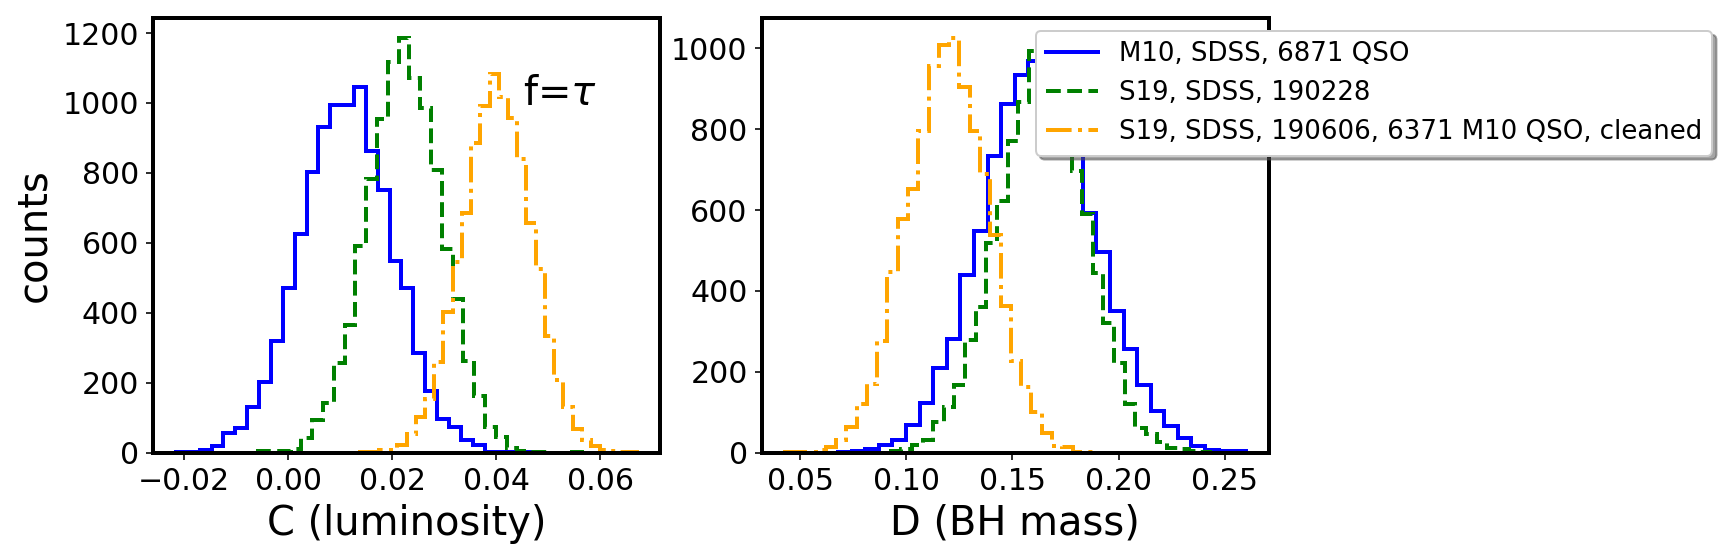

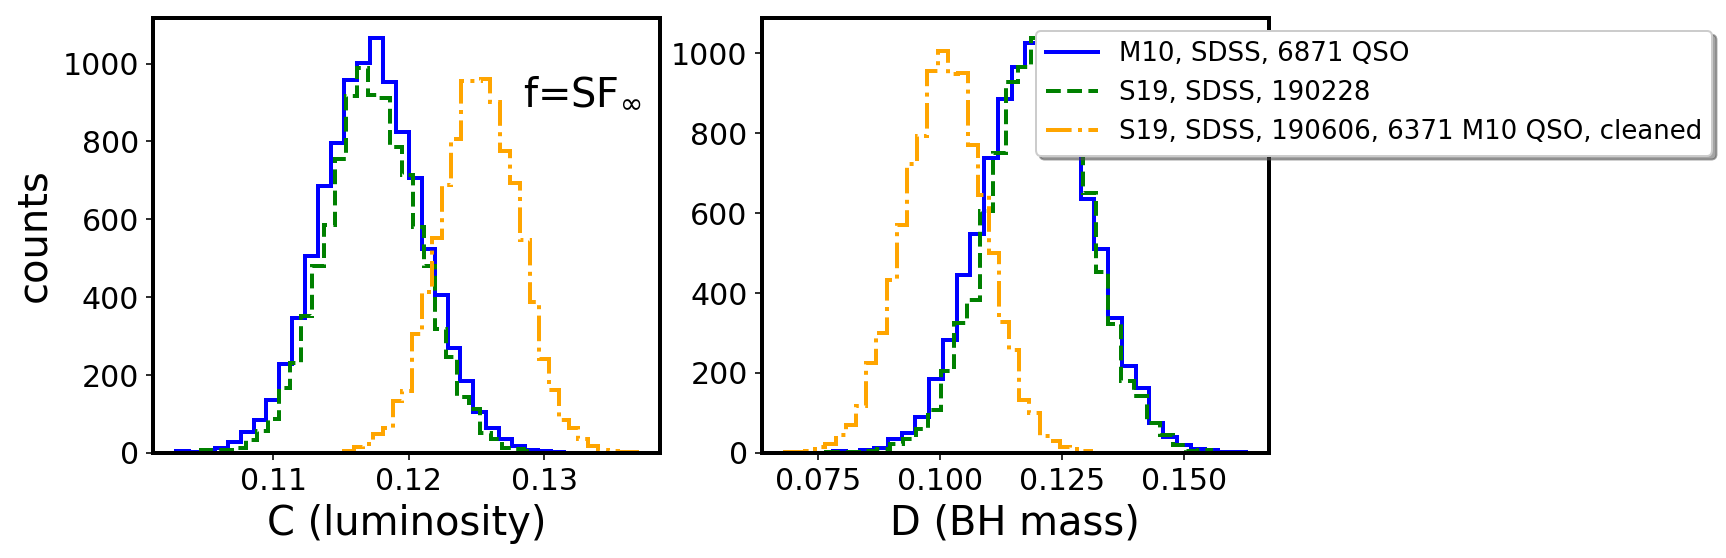

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
band = 3 

 # 'tau'# 'SF'#'tau' #  'SF' # \tau

length = 10
results = {'f': np.zeros(length).astype(str), 
           'source':np.zeros(length).astype(str),
           'A':np.zeros(length).astype(float), 
           'A_unc':np.zeros(length).astype(float),
           'B':np.zeros(length).astype(float), 
           'B_unc':np.zeros(length).astype(float),
           'C':np.zeros(length).astype(float),  
           'C_unc':np.zeros(length).astype(float), 
           'D':np.zeros(length).astype(float) , 
           'D_unc':np.zeros(length).astype(float)
          }

catalog = 'MI_Z2'# 'M_i_corr' #  # 'M_i_corr' # 'M_i_corr  
pre = 'Shen2011'# 'Shen2008'# 
ds = [      '../IDL/190729_M10_'+catalog+'/',
    #'../IDL/M10_line5_ACD_MI_Z2/',
'../IDL/190228_celerite_'+catalog+'_SDSS/',
#'../IDL/190409_celerite_'+catalog+'_SDSS/',
#'../IDL/190606_celerite_'+catalog+'_SDSS/',
'../IDL/190606_celerite_'+catalog+'_SDSS_M10_good/',   
#'../IDL/190930_celerite_'+catalog+'_SDSS_M10_good/',
      
     ]

colors= ['blue',  'green', 'orange',  'red', 'magenta']
ls = ['solid' ,  'dashed', 'dashdot', 'dotted', 'dashed' ]
# labels=  ['M10, SDSS',
#          'S19, SDSS raw',
#          'S19, SDSS cleaned',
#          'S19, SDSS-PS1 ']
labels = ['M10, SDSS, 6871 QSO', 
         'S19, SDSS, 190228', 
          #'S19, SDSS, 190409, all 9246 QSO', 
         # 'S19, SDSS, 190606, all 8516 QSO',
          'S19, SDSS, 190606, 6371 M10 QSO, cleaned',
#          'S19, SDSS, 190930, 6370 M10 QSO, raw'
         ]
k = 0 
for par in ['tau','SF',] : 
    f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'
    lw=2
    A=[]; C=[]; D=[]
    fig,ax = plt.subplots(1,2, figsize=(10,4))
    i = 0 
    ax_legend_handles = [] 
    nbins = 30
    for d in ds : 
        results['f'][k] = par
        results['source'][k] = labels[i] 
        
        print(' ')
        print(d)
        post = Table.read(d+f, format='fits')
        
        
        results['A'][k] = np.mean(post['ALPHA'])
        results['A_unc'][k] = np.std(post['ALPHA'])
        
        if par is 'tau':
            results['B'][k] = 0.17
            results['B_unc'][k] = 0.02
        if par is 'SF' : 
            results['B'][k] = -0.479
            results['B_unc'][k] = 0.005
        
        results['C'][k] = np.mean(post['BETA'][:,0])
        results['C_unc'][k] = np.std(post['BETA'][:,0])
        
        results['D'][k] = np.mean(post['BETA'][:,1])
        results['D_unc'][k] = np.std(post['BETA'][:,1])
        
        

        ax[0].hist(post['BETA'][:,0],histtype='step',color=colors[i],lw= lw,
                   ls=ls[i],bins=nbins)
        print(band, 'mean C=', np.mean(post['BETA'][:,0]))
        #results['']
        #C.append(np.mean(post['BETA'][:,0]))

        ax[1].hist(post['BETA'][:,1],histtype='step',color=colors[i],lw=lw ,
                   ls=ls[i],bins=nbins)
        print(band, 'mean D=', np.mean(post['BETA'][:,1]))
        #D.append(np.mean(post['BETA'][:,1]))

        line = mlines.Line2D([], [],  color=colors[i], label=labels[i],lw=2,
                            ls=ls[i])
        ax_legend_handles.append(line)
        i += 1 
        k += 1 
    ax[1].legend(loc='upper right', handles = ax_legend_handles,
                 bbox_to_anchor=(1.9, 1.0),
                 ncol=1, fancybox=True, shadow=True, fontsize=13 )

    ax[0].set_xlabel('C (luminosity)')
    ax[1].set_xlabel('D (BH mass)')
    ax[0].set_ylabel('counts')
    if par is 'SF':
        func = par+r'$_{\infty}$'
    if par is 'tau':
        func = r'$\tau$'

    ax[0].text(0.73,0.8, 'f='+func,transform=ax[0].transAxes, fontsize=20)
    figname  = 'posterior_IDL_Chelsea_Celerite_CD_'+catalog+'_'+par+'_SDSS_only_.png'
    print('Saving as ', figname)
    plt.savefig(figname, bbox_inches='tight',
               dpi=100)

## Results for M10 / Celerite :  production   (Fig.19/20) <a id='celeriteTauSF'></a>

In the final version we just plot Celerite results for SDSS and SDSS-PS1, not to confuse the reader with intermingling of the M10 results. 

 
../IDL/190807_celerite_MI_Z2_SDSS_M10_good/
3 mean C= 0.12546597145850893
3 mean D= 0.10362488999283885
 
../IDL/190807_celerite_MI_Z2_SDSS-PS1_M10_good/
3 mean C= 0.11757886788175752
3 mean D= 0.11753837793751368
Saving as  Fig_19-20_MI_Z2_SF.png
 
../IDL/190807_celerite_MI_Z2_SDSS_M10_good/
3 mean C= 0.04152768292163572
3 mean D= 0.1269360017627791
 
../IDL/190807_celerite_MI_Z2_SDSS-PS1_M10_good/
3 mean C= 0.0353037167484119
3 mean D= 0.14087363878183895
Saving as  Fig_19-20_MI_Z2_tau.png


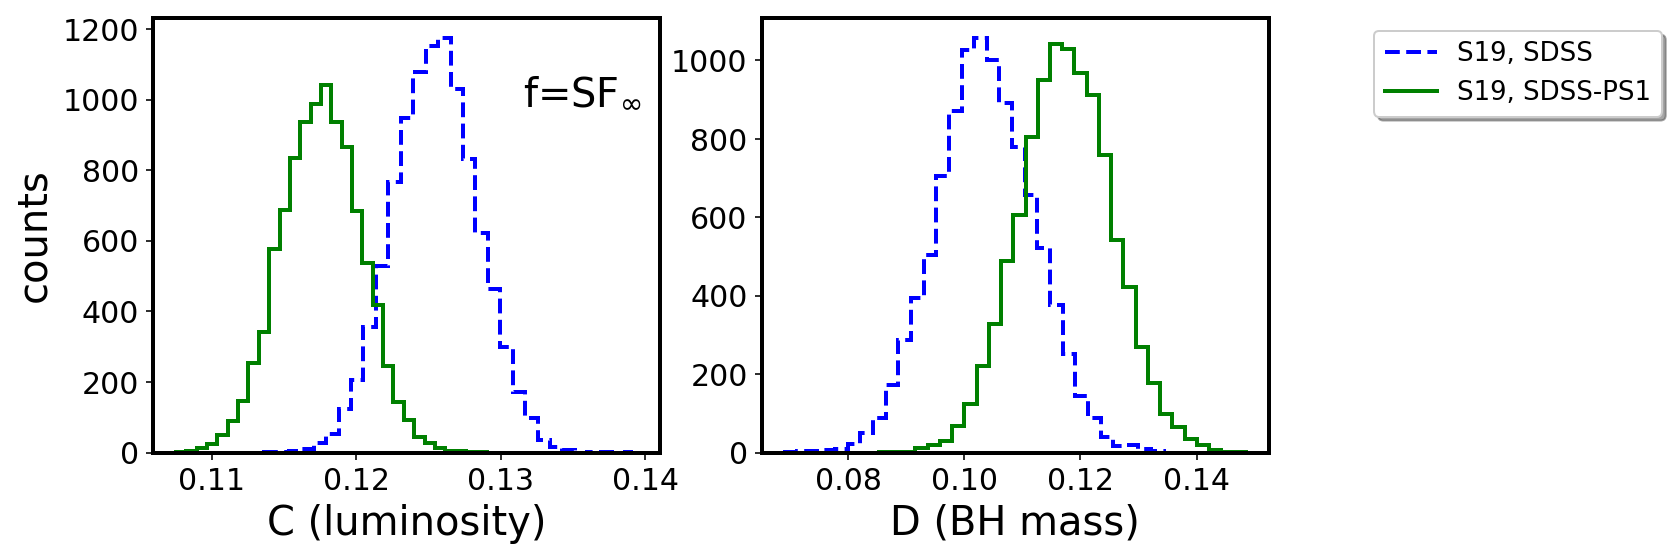

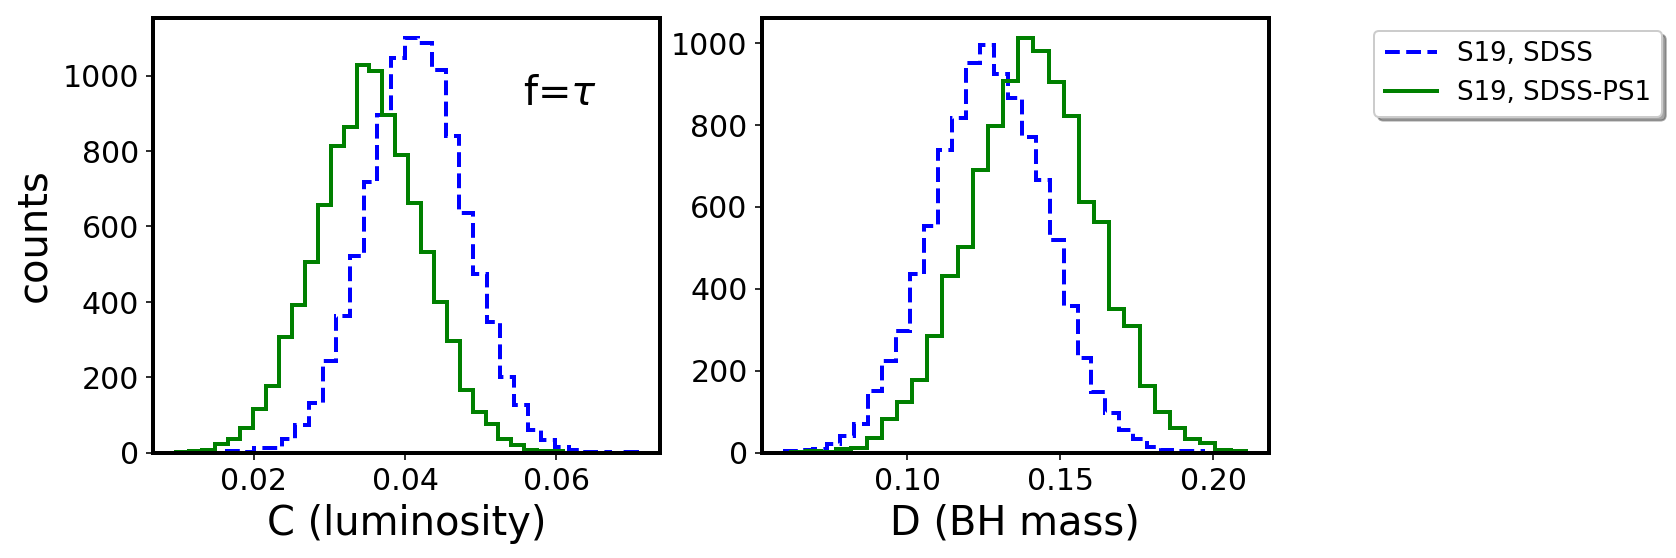

In [16]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
band = 3 

 # 'tau'# 'SF'#'tau' #  'SF' # \tau

length = 18
results = {'f': np.zeros(length).astype(str), 
           'source':np.zeros(length).astype(str),
           'A':np.zeros(length).astype(float), 
           'A_unc':np.zeros(length).astype(float),
           'B':np.zeros(length).astype(float), 
           'B_unc':np.zeros(length).astype(float),
           'C':np.zeros(length).astype(float),  
           'C_unc':np.zeros(length).astype(float), 
           'D':np.zeros(length).astype(float) , 
           'D_unc':np.zeros(length).astype(float)
          }

catalog = 'MI_Z2'# 'M_i_corr' #  # 'M_i_corr' # 'M_i_corr  
pre = 'Shen2011'# 'Shen2008'# 
# date = '190228'
# ds = ['../IDL/M10_line5_ACD_'+catalog+'/',
# '../IDL/'+date+'_celerite_'+catalog+'_SDSS/',
# '../IDL/'+date+'_celerite_'+catalog+'_SDSS-PS1/']
date = '190807'#'190606'#'190807'#'190606'

sup = '1'# '1' # good,  '2' : all 
survey = 'SDSS'
if sup is '1':
    title  = ''#'v1: 6371 quasars that fulfill M10 selection'
    ds = [#'../IDL/190729_M10_'+catalog+'_good/', # 6371 / 6871  
        #  '../IDL/190228_celerite_'+catalog+'_SDSS/',  # 4968  of 6444 , the inner join ... 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_M10_good/',  # 6371 / 8516 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'-PS1_M10_good/', # 6371 / 8516
#     '../IDL/'+date+'_celerite_'+catalog+'_SDSS_subset/' , # 3567 / 4968 in 190228 that were in M10
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S0/', # 3000 / 6371 
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S1/', # 3000 / 6371
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S2/', # 3000 / 6371
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S3/', # 3000 / 6371
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S4/', # 3000 / 6371
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S5/', # 3000 / 6371
         ]
if sup is '2':
    title = 'v2: 8516 SDSS-PS1 quasars with Celerite results'
    ds = [#'../IDL/190729_M10_'+catalog+'/', # 6371 / 6871 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'/', # all 8516
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'-PS1/'# all 8516
         ]


# matched to the 6871 M10 r-band that  fulfill M10 selection criteria...

colors= ['blue','green', 'orange',  'red', 'magenta', 'purple', 'cyan']
ls = ['dashed' ,'solid', 'dashed', 'dotted', 'dashed',  'dotted', 'dotted']
labels = [#'M10, SDSS 6371',
         # 'S19, SDSS 4968',
        # 'S19, SDSS raw',
         'S19, SDSS',
         'S19, SDSS-PS1',
#          'S19, '+survey+' SS 6371',
#          'S19 '+survey+' S0: 3000 / 6371',  # three random subsets of M10 good set 
#          'S19 '+survey+' S1: 3000 / 6371', 
#          'S19 '+survey+' S2: 3000 / 6371',
#          'S19 '+survey+' S3: 3000 / 6371',
#          'S19 '+survey+' S4: 3000 / 6371',
#          'S19 '+survey+' S5: 3000 / 6371',
         ]
# labels = ['M10, 6871 QSO, SDSS', 'S19, 6371 QSO, SDSS ', 
#           'S19, 6371 QSO, SDSS-PS1 ',
#           'S19, 8516 QSO, SDSS',
#           'S19, 8516 QSO, SDSS-PS1'
#          ]
k = 0 
for par in ['SF','tau' ] : 
    f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'
    lw=2
    A=[]; C=[]; D=[]
    fig,ax = plt.subplots(1,2, figsize=(10,4))
    i = 0 
    ax_legend_handles = [] 
    nbins = 30
    for d in ds : 
        results['f'][k] = par
        results['source'][k] = labels[i] 
        
        print(' ')
        print(d)
        post = Table.read(d+f, format='fits')
        
        
        results['A'][k] = np.mean(post['ALPHA'])
        results['A_unc'][k] = np.std(post['ALPHA'])
        
        if par is 'tau':
            results['B'][k] = 0.17
            results['B_unc'][k] = 0.02
        if par is 'SF' : 
            results['B'][k] = -0.479
            results['B_unc'][k] = 0.005
        
        results['C'][k] = np.mean(post['BETA'][:,0])
        results['C_unc'][k] = np.std(post['BETA'][:,0])
        
        results['D'][k] = np.mean(post['BETA'][:,1])
        results['D_unc'][k] = np.std(post['BETA'][:,1])
        
        

        ax[0].hist(post['BETA'][:,0],histtype='step',color=colors[i],lw= lw,
                   ls=ls[i],bins=nbins, )#density=True)
        print(band, 'mean C=', np.mean(post['BETA'][:,0]))
        #results['']
        #C.append(np.mean(post['BETA'][:,0]))

        ax[1].hist(post['BETA'][:,1],histtype='step',color=colors[i],lw=lw ,
                   ls=ls[i],bins=nbins,)# density=True)
        print(band, 'mean D=', np.mean(post['BETA'][:,1]))
        #D.append(np.mean(post['BETA'][:,1]))

        line = mlines.Line2D([], [],  color=colors[i], label=labels[i],lw=2,
                            ls=ls[i])
        ax_legend_handles.append(line)
        i += 1 
        k += 1 
    ax[1].legend(loc='upper right', handles = ax_legend_handles,
                 bbox_to_anchor=(1.8, 1.0),
                 ncol=1, fancybox=True, shadow=True, fontsize=13 )

    ax[0].set_xlabel('C (luminosity)')
    ax[1].set_xlabel('D (BH mass)')
    ax[0].set_ylabel('counts')
    if par is 'SF':
        func = par+r'$_{\infty}$'
    if par is 'tau':
        func = r'$\tau$'

    ax[0].text(0.73,0.8, 'f='+func,transform=ax[0].transAxes, fontsize=20)
    #fig.suptitle(title, fontsize=18)
    figname  = 'Fig_19-20_'+catalog+'_'+par+'.png'
    print('Saving as ', figname)
    plt.savefig(figname, bbox_inches='tight',
               dpi=100)

## Results for M10 / Celerite :  production ( Table 2 ) <a id='celeriteTauSF_table'></a>

Make an M10  Table.1  equivalent, using these results ...  <a id='table2'></a>

In [21]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
band = 3 # r-band 

# the table would include M10 , SDSS r-band,  
length = 6 # 2 params x 3 sources 
results = {'f': np.zeros(length).astype(str), 
           'source':np.zeros(length).astype(str),
           'A':np.zeros(length).astype(float), 
           'A_unc':np.zeros(length).astype(float),
           'B':np.zeros(length).astype(float), 
           'B_unc':np.zeros(length).astype(float),
           'C':np.zeros(length).astype(float),  
           'C_unc':np.zeros(length).astype(float), 
           'D':np.zeros(length).astype(float) , 
           'D_unc':np.zeros(length).astype(float)
          }

catalog = 'MI_Z2'# 
pre = 'Shen2011'#
date = '190807'
sup = '1'# '1': good,  '2' : all 
survey = 'SDSS'
if sup is '1':
    title  = ''#'v1: 6371 quasars that fulfill M10 selection'
    ds = ['../IDL/190729_M10_'+catalog+'_good/', # 6371 / 6871  . 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_M10_good/',  # 6371 / 8516 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'-PS1_M10_good/', # 6371 / 8516
         ]
if sup is '2':
    title = 'v2: 8516 SDSS-PS1 quasars with Celerite results'
    ds = ['../IDL/190729_M10_'+catalog+'/', # 6871 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'/', # all 8516
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'-PS1/'# all 8516
         ]

labels = ['M10, SDSS',
         'S19, SDSS',
         'S19, SDSS-PS1',
         ]
k = 0 
for par in ['tau', 'SF' ] : 
    f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'
    i = 0 
    for d in ds : 
        results['f'][k] = par
        results['source'][k] = labels[i] 
        
        post = Table.read(d+f, format='fits')

        results['A'][k] = np.mean(post['ALPHA'])
        results['A_unc'][k] = np.std(post['ALPHA'])
        
        if par is 'tau':
            results['B'][k] = 0.17
            results['B_unc'][k] = 0.02
        if par is 'SF' : 
            results['B'][k] = -0.479
            results['B_unc'][k] = 0.005
        
        results['C'][k] = np.mean(post['BETA'][:,0])
        results['C_unc'][k] = np.std(post['BETA'][:,0])
        
        results['D'][k] = np.mean(post['BETA'][:,1])
        results['D_unc'][k] = np.std(post['BETA'][:,1])
    
        i += 1 
        k += 1 

# make an AstroPy table from the dictionary
restab = Table(results)
fname = 'Table2_IDL_fit_results_'+date+'_v'+sup+'.txt'
# store the results 
restab.write(fname,  format='ascii', overwrite=True)
print('Saved as %s'%fname)

Saved as Table2_IDL_fit_results_190807_v1.txt


In [22]:
restab

f,source,A,A_unc,B,B_unc,C,C_unc,D,D_unc
str32,str32,float64,float64,float64,float64,float64,float64,float64,float64
tau,"M10, SDSS",2.5003792938335443,0.02740897262934101,0.17,0.02,0.029518762014690714,0.009330608598567183,0.17770775941826492,0.027426694862385543
tau,"S19, SDSS",2.515315749570737,0.019011479191430283,0.17,0.02,0.04152768292163572,0.006501660540616111,0.1269360017627791,0.018567698270937166
tau,"S19, SDSS-PS1",2.597247560705043,0.020337602856107972,0.17,0.02,0.0353037167484119,0.006958031624535812,0.14087363878183895,0.020152308047881935
SF,"M10, SDSS",-0.48588158327109643,0.011838393501100506,-0.479,0.005,0.11867246235177449,0.004052063765105348,0.12060496659834957,0.01166198575467962
SF,"S19, SDSS",-0.5425504937284109,0.008513941642706932,-0.479,0.005,0.12546597145850893,0.00291138431615709,0.10362488999283885,0.00837987405798716
SF,"S19, SDSS-PS1",-0.4755806735381703,0.00808305953658345,-0.479,0.005,0.11757886788175752,0.002762632300474127,0.11753837793751368,0.008018834992549387


In [23]:

# do the LaTeX formatting ... 

# idea for that from https://gist.github.com/PBarmby/e4384a81cf2e1c53365c
Nround = 3 
A_ = np.array(['$'+str(row['A'].round(Nround)) +\
               '\\pm' + str(row['A_unc'].round(Nround))+ '$' for row in restab])
B_ = np.array(['$'+str(row['B'].round(Nround)) +\
               '\\pm' + str(row['B_unc'].round(Nround))+ '$' for row in restab])
C_ = np.array(['$'+str(row['C'].round(Nround)) +\
                '\\pm' + str(row['C_unc'].round(Nround))+ '$' for row in restab])
D_ = np.array(['$'+str(row['D'].round(Nround)) +\
                '\\pm' + str(row['D_unc'].round(Nround))+ '$' for row in restab])
f_ = [r'$\tau$', '', '', 'SF'+'$_{\infty}$', '', '']

# saving as a LaTeX table http://docs.astropy.org/en/stable/api/astropy.io.ascii.Latex.html 
res = Table(data = [f_, restab['source'], A_, B_,  C_, D_],
           names = ['\colhead{$f$}', '\colhead{Source}', '\colhead{$A$'+'(offset)}', 
                    '\colhead{$B(\lambda_{RF})$}',
                    '\colhead{$C (M_{i})$}', 
                    '\colhead{$D (M_{\mathrm{BH}})$}'])
fname = 'Table2_IDL_fit_results_latex_'+date+'_v'+sup+'.txt'
res.write(fname, format='latex', overwrite=True)
print('Saved as %s'%fname)
res

Saved as Table2_IDL_fit_results_latex_190807_v1.txt


\colhead{$f$},\colhead{Source},\colhead{$A$(offset)},\colhead{$B(\lambda_{RF})$},\colhead{$C (M_{i})$},\colhead{$D (M_{\mathrm{BH}})$}
str13,str32,str16,str16,str15,str15
$\tau$,"M10, SDSS",$2.5\pm0.027$,$0.17\pm0.02$,$0.03\pm0.009$,$0.178\pm0.027$
,"S19, SDSS",$2.515\pm0.019$,$0.17\pm0.02$,$0.042\pm0.007$,$0.127\pm0.019$
,"S19, SDSS-PS1",$2.597\pm0.02$,$0.17\pm0.02$,$0.035\pm0.007$,$0.141\pm0.02$
SF$_{\infty}$,"M10, SDSS",$-0.486\pm0.012$,$-0.479\pm0.005$,$0.119\pm0.004$,$0.121\pm0.012$
,"S19, SDSS",$-0.543\pm0.009$,$-0.479\pm0.005$,$0.125\pm0.003$,$0.104\pm0.008$
,"S19, SDSS-PS1",$-0.476\pm0.008$,$-0.479\pm0.005$,$0.118\pm0.003$,$0.118\pm0.008$


$\log_{10}{(\tau_{RF})} = A + B \log_{10}\left(\frac{\lambda_{RF}}{4000  }\right) + C (M_{i} + 23) + D \log_{10}{\left( \frac{M_{BH}}{10^{9}  } \right)} + E \log_{10}{(1+z)}$

In [123]:
# Read in a file with MBH, Mi   used for IDL fitting  
cel = Table.read('190228_celerite_J1_shen2007-2011.txt', format='ascii')

Using ACD  from SDSS-only 

(array([2.350e+02, 1.343e+03, 1.074e+03, 4.110e+02, 1.170e+02, 4.400e+01,
        1.200e+01, 9.000e+00, 2.000e+00, 1.000e+00]),
 array([-0.85248385, -0.46720243, -0.08192102,  0.30336039,  0.6886418 ,
         1.07392321,  1.45920463,  1.84448604,  2.22976745,  2.61504886,
         3.00033028]),
 <a list of 1 Patch objects>)

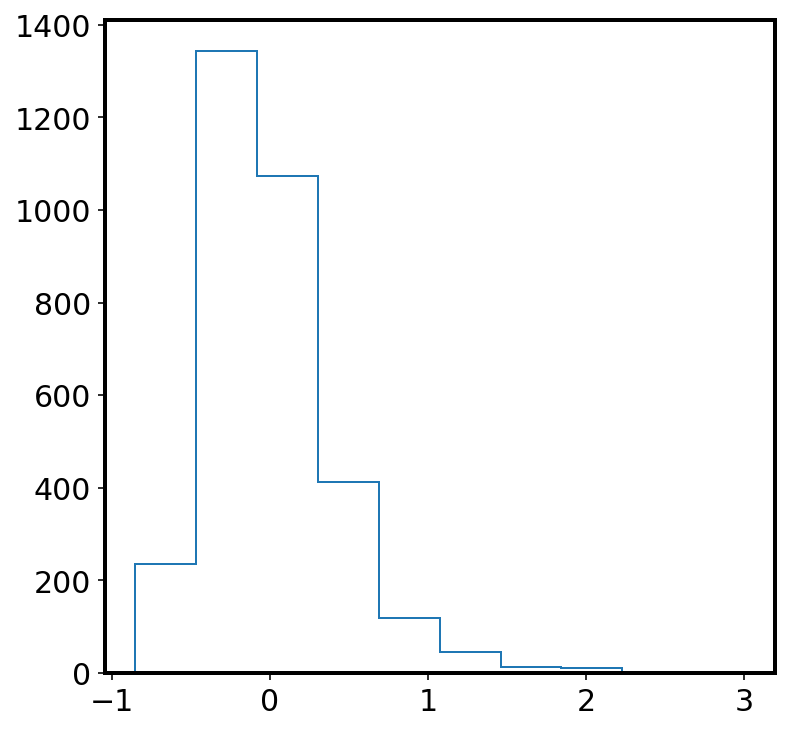

In [124]:
# to get these tau ACD, I used M_i_corr (z=2), and mass_BH  ( from DB_QSO )
# Using tauEXP_sdss only 
A = 2.692
C = 0.0458
D = 0.244

B = 0.17  # fixed 
x = np.log10(cel['lambdaRF'] / 4000 )
y = cel['M_i_corr'] + 23 
z = cel['mass_BH'] - 9  # mass_BH is already a log 
select = cel['mass_BH']  > 0 

log10tauRF_IDL = A + B*x[select]  + C*y[select] + D*z[select]  # from IDL fits 
tauRF_IDL = np.power(10,log10tauRF_IDL)

log10tauRF_cel = np.log10(cel['tauEXP_sdss'][select]) -\
                np.log10(1 + cel['redshift'][select])
tauRF_cel = np.power(10,log10tauRF_cel)
a = np.log10(tauRF_IDL / tauRF_cel)

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.hist(np.log10(tauRF_IDL / tauRF_cel), histtype='step')

(array([ 87., 418., 643., 652., 522., 393., 270., 141.,  82.,  40.]),
 array([-1.18335958, -0.88649442, -0.58962925, -0.29276409,  0.00410107,
         0.30096623,  0.59783139,  0.89469656,  1.19156172,  1.48842688,
         1.78529204]),
 <a list of 1 Patch objects>)

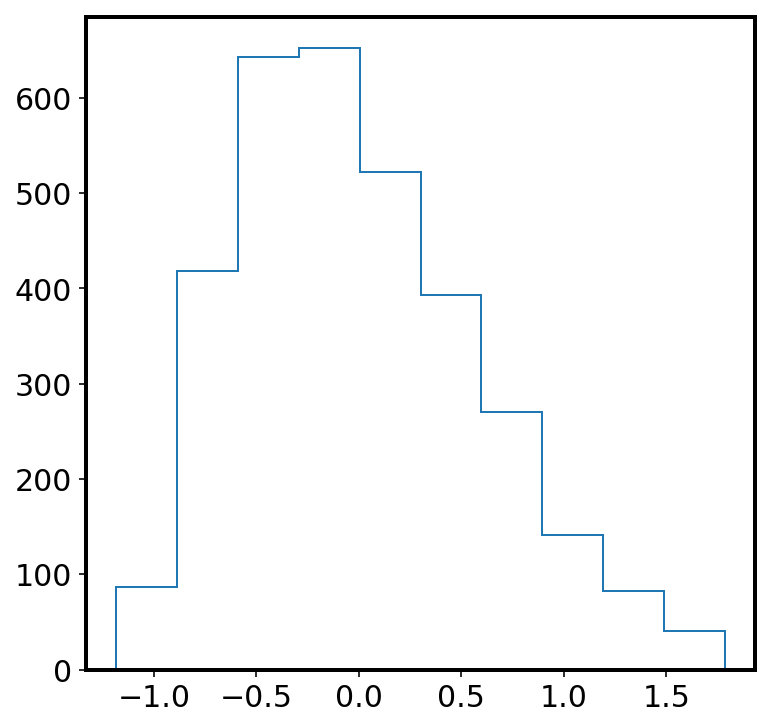

In [125]:
# to get these tau ACD, I used M_i_corr (z=2), and mass_BH  ( from DB_QSO )
# Using tauEXP_sdss-ps1  
A = 2.356
C = 0.1026
D = 0.203

B = 0.17  # fixed 
x = np.log10(cel['lambdaRF'] / 4000 )
y = cel['M_i_corr'] + 23 
z = cel['mass_BH'] - 9  # mass_BH is already a log 
select = cel['mass_BH']  > 0 

log10tauRF_IDL = A + B*x[select]  + C*y[select] + D*z[select]  # from IDL fits 

tauRF_IDL = np.power(10,log10tauRF_IDL)
#tauOBS_IDL = tauRF_IDL * (1+cel['redshift'][select])

log10tauRF_cel = np.log10(cel['tauEXP_sdss-ps1'][select]) -\
                np.log10(1 + cel['redshift'][select])
tauRF_cel = np.power(10,log10tauRF_cel)
#tauOBS_cel = cel['tauEXP_sdss-ps1'][select]

#plt.hist(log10tauRF_IDL, histtype='step', label='IDL')
#plt.hist(log10tauRF_cel, histtype='step', label='Celerite')
#plt.legend()
fig,ax = plt.subplots(1,1,figsize=(6,6))
b = np.log10(tauRF_IDL / tauRF_cel) 
# there is no difference whether I'm comparing here
# rest-frame tau or  observed frame tau,
# because the same shifts have been applied to all quasars 
ax.hist(np.log10(tauRF_IDL / tauRF_cel), histtype='step')


In [126]:
# only select r-band from Chelsea's results,
# that were used for IDL fitting ...
results  = Table.read('../code/s82drw_ugriz.txt', format='ascii')
ch = results[results['band'] == 3]
#ch

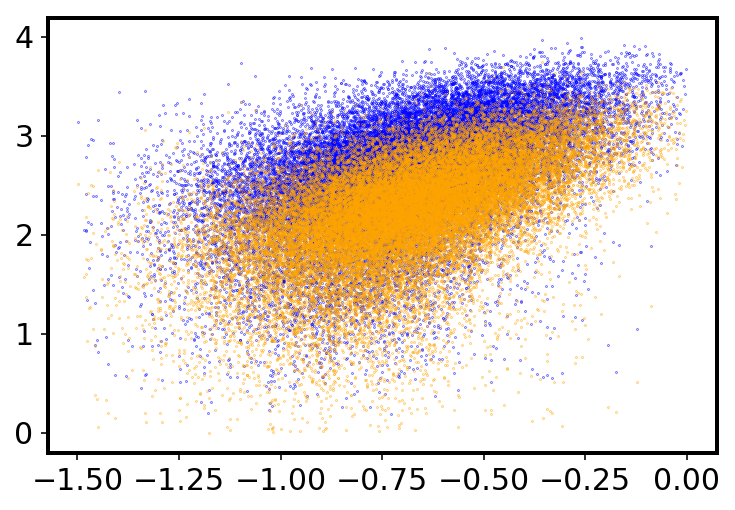

In [127]:
# Show that the log10tau is hte observed frame, not the rest-frame, 
# by reproducing Fig;3 with the 33112 light curves (~1 light curve per band )

extent = [-1.5,0,0,4]


x = np.log10(results['SFinf'])
# assuming stored as rest-frame already : blue  
y = results['log10tau'] 


mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])
m = mx & my 
plt.scatter(x[m], y[m], c='blue', s=0.05)

# assuming stored as obs-frame  : orange 
y = results['log10tau'] - np.log10(1. + results['redshift'])  
mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])
m = mx & my 
plt.scatter(x[m], y[m], c='orange', s=0.05)


So from the above we see that the orange dots (assuming log10tau is obs-frame) are much more aligned with Fig.3 in the paper than the blue dots (assuming log10tau is rest-frame). Therefore log10tau  on the website is the **observed frame** and needs to be divided by 1+z  to shift to rest frame. 

(array([2.100e+01, 3.960e+02, 1.265e+03, 1.558e+03, 7.150e+02, 2.410e+02,
        8.800e+01, 3.100e+01, 1.100e+01, 1.000e+00]),
 array([-1.5 , -1.05, -0.6 , -0.15,  0.3 ,  0.75,  1.2 ,  1.65,  2.1 ,
         2.55,  3.  ]),
 <a list of 1 Patch objects>)

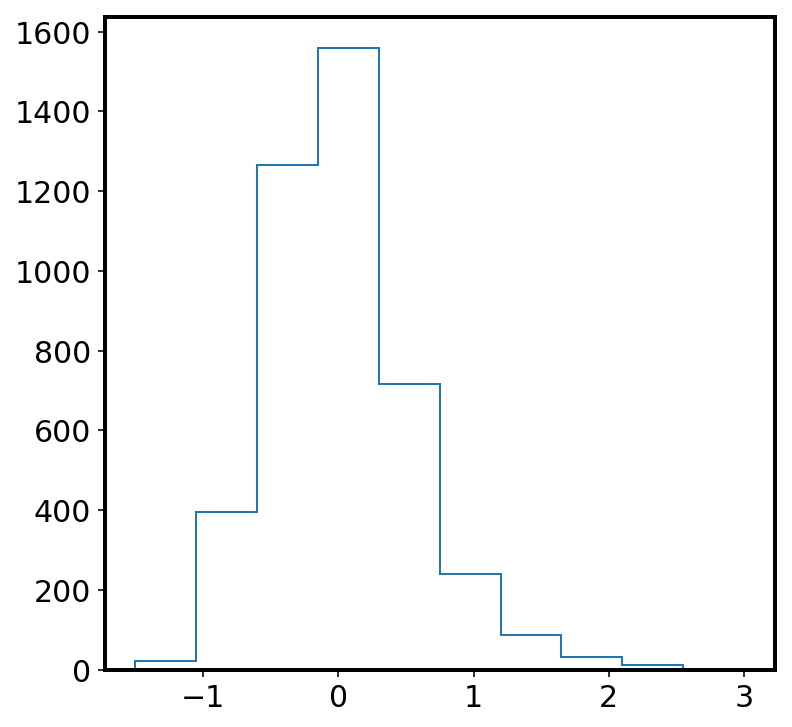

In [128]:
# Here compare IDL fits to Chelsea's r-band only tau 
A = 2.542
C = 0.0411
D = 0.2759

B = 0.17  # fixed 
x = np.log10(ch['lambdaRF'] / 4000 )
y = ch['M_i_corr'] + 23 
z = ch['mass_BH'] - 9  # mass_BH is already a log 
select = ch['mass_BH']  > 0 

log10tauRF_IDL = A + B*x[select]  + C*y[select] + D*z[select]  # from IDL fits 
tauRF_IDL = np.power(10,log10tauRF_IDL)
#tauOBS_IDL = tauRF_IDL * (1+cel['redshift'][select])


log10tauOBS_ch = ch['log10tau'][select] # it's obs frame and needs to be shifted... 
log10tauRF_ch = log10tauOBS_ch -  np.log10(1. + ch['redshift'][select])    
tauRF_ch = np.power(10,log10tauRF_ch)

#tauOBS_cel = cel['tauEXP_sdss-ps1'][select]

#plt.hist(log10tauRF_IDL, histtype='step', label='IDL')
#plt.hist(log10tauRF_cel, histtype='step', label='Celerite')
#plt.legend()
fig,ax = plt.subplots(1,1,figsize=(6,6))

# there is no difference whether I'm comparing here
# rest-frame tau or  observed frame tau,
# because the same shifts have been applied to all quasars 
c = np.log10(tauRF_IDL / tauRF_ch)
ax.hist(np.log10(tauRF_IDL / tauRF_ch), histtype='step',
       range=(-1.5,3))



Plot the ratios of tau -->  A,C,D  given  M_i,  M_BH   ,  to  tau < -- A,C,D, given M_i, M_BH  . 

For each tau, I'm using A,C,D  obtained from fitting these tau with IDL, and M_i_corr, mass_BH (DB_QSO values). Thus there are three sets of A,C,D : 

* using SDSS-only Celerite tauEXP_sdss :
  * A = 2.692, C = 0.0458 , D = 0.244
* using SDSS and PS1 Celerite tauEXP_sdss-ps1 : 
  * A = 2.356, C = 0.1026, D = 0.203
* using Chelsea's SDSS r-band tau  log10tau : 
  * A = 2.69,  C = -0.048, D = 0.256




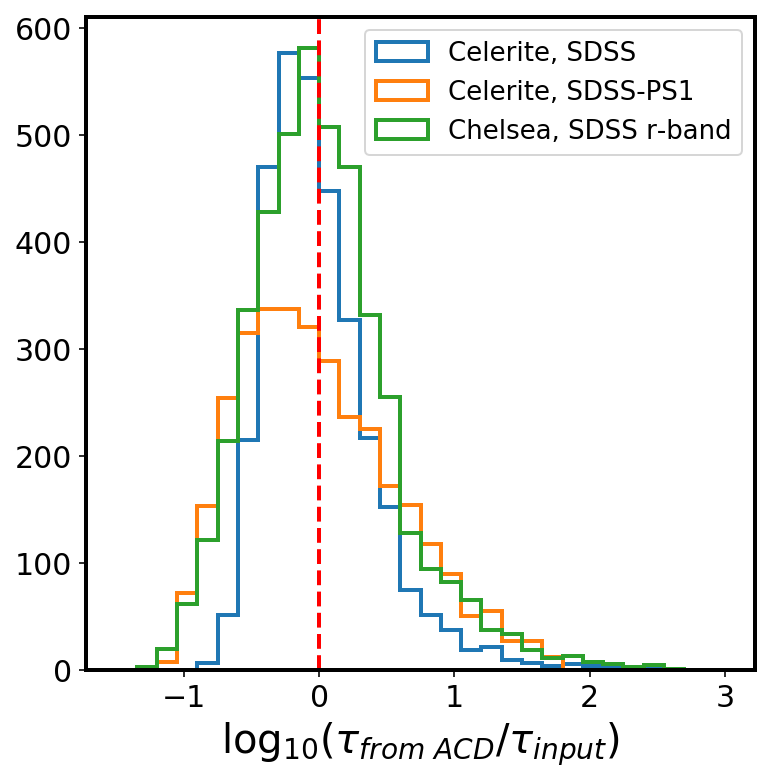

In [130]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
N = 30
r = (-1.5,3)

ax.hist(a, histtype='step', lw=2, label='Celerite, SDSS',range=r, bins=N)
ax.hist(b, histtype='step', lw=2, label='Celerite, SDSS-PS1',range=r,bins=N)
ax.hist(c, histtype='step', lw=2, label='Chelsea, SDSS r-band',range=r,bins=N)
ax.axvline(0, ls='--', lw=2, c='red')
ax.legend(fontsize=13)
ax.set_xlabel(r'$\log_{10}{(\tau_{from\,\,ACD} / \tau_{input})}$')
plt.savefig('IDL_test.png', bbox_inches='tight', dpi=100)